In [7]:
# importazione librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Nadam
from timeit import default_timer as timer

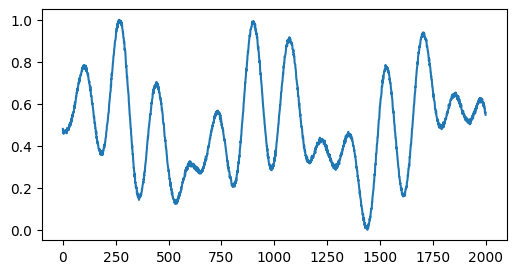

In [8]:
# configurazione parametri per generare un dataset
# utile per essere utilizzato in "sequenze temporali"
n = 2000  # 2000 esempi
test_split_point = 1600 # di cui 400 usati per la validazione del modello

t = np.arange(0, n) # lista di numeri da 0 a 1999

# costruzione del dataset
x = (np.sin(0.008 * t) + np.sin(0.03 * t) - np.sin(0.04 * t)) * 6 + (np.random.rand(n) - np.random.rand(n)) / 2

x_min = min(x)
x_max = max(x)

x = (x - x_min) / (x_max - x_min)

df = pd.DataFrame(x)


# rappresentazione grafica della distribuzione creata
plt.figure(figsize=(6, 3))
plt.plot(df)
plt.show() 


In [9]:
# conversione in array numpy
values = df.values
values.shape

(2000, 1)

In [10]:
# costruzione delle sequenze temporali
step = 100

train_x, train_y = (values[:test_split_point], step)
test_x, test_y = (values[test_split_point:], step)
train_x.shape

(1600, 1)

In [11]:
# Vedi analisi dimensionale sotto
def convert_to_matrix(data, step):

    x, y = [], []

    for i in range(len(data) - step):
        d = i + step  
        x.append(data[i:d,])
        y.append(data[d,])
        
    return np.array(x), np.array(y)

train_x, train_y = convert_to_matrix(values[:test_split_point], step)
test_x, test_y = convert_to_matrix(values[test_split_point:], step)

In [12]:
print('Shape addestramento   x', train_x.shape, '   y', train_y.shape)
print('Shape test            x', test_x.shape, '    y', test_y.shape)

Shape addestramento   x (1500, 100, 1)    y (1500, 1)
Shape test            x (300, 100, 1)     y (300, 1)


In [14]:
# costruzione del modello
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(step, 1), return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 100, 64)           4224      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 100, 64)           8256      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,905
Trainable params: 23,905
Non-trai

In [15]:
# addestramento del modello
start = timer()
rnn_h = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
rnn_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 3s - loss: 0.1070 - mean_absolute_error: 0.2497 - 3s/epoch - 1s/step
Epoch 2/10
3/3 - 1s - loss: 0.0320 - mean_absolute_error: 0.1393 - 575ms/epoch - 192ms/step
Epoch 3/10
3/3 - 1s - loss: 0.0518 - mean_absolute_error: 0.2008 - 574ms/epoch - 191ms/step
Epoch 4/10
3/3 - 0s - loss: 0.0137 - mean_absolute_error: 0.0874 - 453ms/epoch - 151ms/step
Epoch 5/10
3/3 - 0s - loss: 0.0063 - mean_absolute_error: 0.0544 - 443ms/epoch - 148ms/step
Epoch 6/10
3/3 - 0s - loss: 0.0028 - mean_absolute_error: 0.0368 - 467ms/epoch - 156ms/step
Epoch 7/10
3/3 - 1s - loss: 0.0017 - mean_absolute_error: 0.0298 - 609ms/epoch - 203ms/step
Epoch 8/10
3/3 - 1s - loss: 0.0013 - mean_absolute_error: 0.0266 - 580ms/epoch - 193ms/step
Epoch 9/10
3/3 - 1s - loss: 0.0018 - mean_absolute_error: 0.0348 - 571ms/epoch - 190ms/step
Epoch 10/10
3/3 - 1s - loss: 0.0068 - mean_absolute_error: 0.0770 - 582ms/epoch - 194ms/step
terminato.


In [16]:
# predizioni (come si comporta il modello su tutto il dataset,
# considerando separatamente i dati di train e di test)
train_predict_rnn = model.predict(train_x)
test_predict_rnn = model.predict(test_x)

10/10 [==============================] - 0s 20ms/step


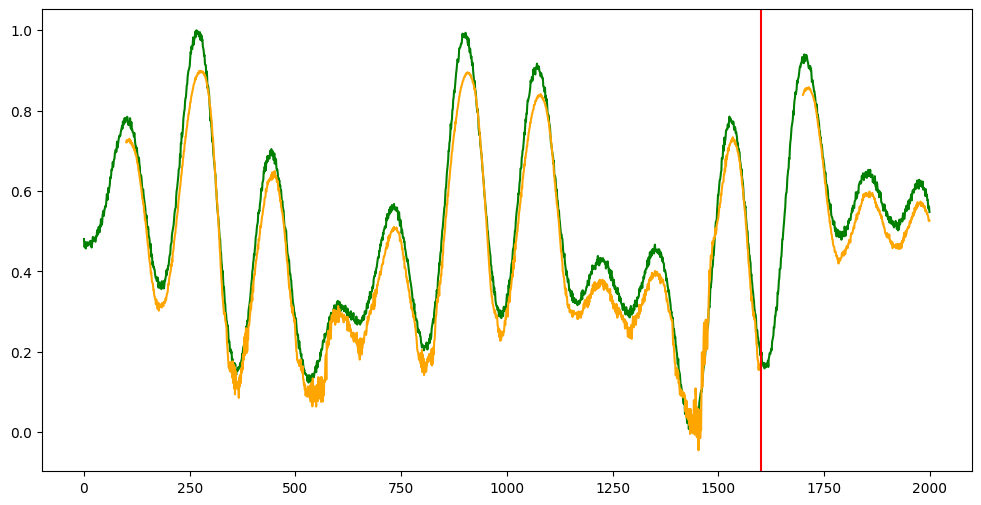

In [17]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_rnn) + step)]
plt.plot(x_train_preds, train_predict_rnn, color='orange')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_rnn))]
plt.plot(x_test_preds, test_predict_rnn, color='orange')

plt.axvline(df.index[test_split_point], c='r')
plt.show() 

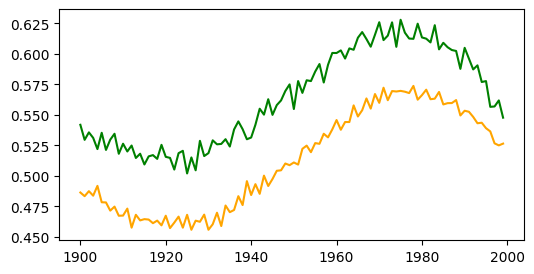

In [18]:
# grafico relativo all'output del modello rispetto
# ai dati reali iniziali - osservazione degli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange')
plt.show()

In [23]:
# costruzione del modello tramite celle LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(step, 1), return_sequences=True))
model_lstm.add(LSTM(units=64, return_sequences=True))
model_lstm.add(LSTM(units=64,))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_lstm.summary()

2023-05-30 15:10:34.037627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:10:34.039790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:10:34.040918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 64)           16896     
                                                                 
 lstm_13 (LSTM)              (None, 100, 64)           33024     
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 86,113
Trainable params: 86,113
Non-trai

2023-05-30 15:10:34.379500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:10:34.380600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:10:34.382363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
# addestramento del modello basato su celle LSTM
start = timer()
lstm_h = model_lstm.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
lstm_t = end - start
print('terminato.')

Epoch 1/10


2023-05-30 15:10:39.877146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:10:39.878934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:10:39.879985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 - 6s - loss: 0.2534 - mean_absolute_error: 0.4485 - 6s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 0.1771 - mean_absolute_error: 0.3668 - 1s/epoch - 437ms/step
Epoch 3/10
3/3 - 1s - loss: 0.0465 - mean_absolute_error: 0.1700 - 1s/epoch - 421ms/step
Epoch 4/10
3/3 - 1s - loss: 0.0216 - mean_absolute_error: 0.1219 - 1s/epoch - 457ms/step
Epoch 5/10
3/3 - 1s - loss: 0.0185 - mean_absolute_error: 0.1138 - 1s/epoch - 431ms/step
Epoch 6/10
3/3 - 1s - loss: 0.0151 - mean_absolute_error: 0.1021 - 1s/epoch - 440ms/step
Epoch 7/10
3/3 - 2s - loss: 0.0121 - mean_absolute_error: 0.0911 - 2s/epoch - 565ms/step
Epoch 8/10
3/3 - 2s - loss: 0.0092 - mean_absolute_error: 0.0789 - 2s/epoch - 625ms/step
Epoch 9/10
3/3 - 2s - loss: 0.0065 - mean_absolute_error: 0.0666 - 2s/epoch - 537ms/step
Epoch 10/10
3/3 - 2s - loss: 0.0136 - mean_absolute_error: 0.0919 - 2s/epoch - 547ms/step
terminato.


In [25]:
# analisi del comportamento del modello
train_predict_lstm = model_lstm.predict(train_x)
test_predict_lstm = model_lstm.predict(test_x)

2023-05-30 15:11:02.896586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:11:02.897652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:11:02.899207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 37ms/step


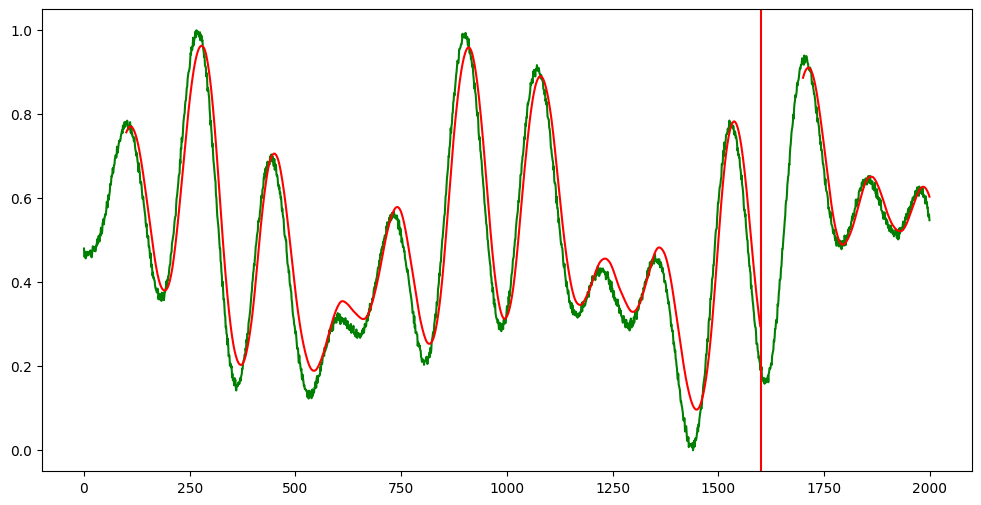

In [26]:
# confronto del comportamento del modello
# rispetto ai dati reali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_lstm) + step)]
plt.plot(x_train_preds, train_predict_lstm, color='red')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_lstm))]
plt.plot(x_test_preds, test_predict_lstm, color='red')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

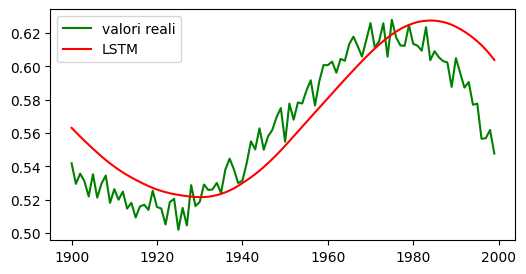

In [28]:
# analisi sugli ultimi 100 esempi predetti rispetto
# ai dati reali iniziali
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green', label='valori reali')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.legend()
plt.show()

In [29]:
# costruzione di un modello basato su celle di tipo GRU
model_gru = Sequential()
model_gru.add(GRU(units=64, input_shape=(step, 1), return_sequences=True))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(GRU(units=64))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(32, activation="relu"))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_gru.summary()

2023-05-30 15:11:43.326792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:11:43.328195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:11:43.329079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 64)           12864     
                                                                 
 gru_1 (GRU)                 (None, 100, 64)           24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 65,953
Trainable params: 65,953
Non-trai

2023-05-30 15:11:43.604668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:11:43.606497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:11:43.607559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [30]:
# addestramento del modello basato su celle GRU
start = timer()
gru_h = model_gru.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
gru_t = end - start
print('terminato.')

Epoch 1/10


2023-05-30 15:11:53.662563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:11:53.665492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:11:53.667946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 - 6s - loss: 0.2096 - mean_absolute_error: 0.4051 - 6s/epoch - 2s/step
Epoch 2/10
3/3 - 1s - loss: 0.1099 - mean_absolute_error: 0.2792 - 1s/epoch - 427ms/step
Epoch 3/10
3/3 - 1s - loss: 0.0253 - mean_absolute_error: 0.1195 - 1s/epoch - 381ms/step
Epoch 4/10
3/3 - 1s - loss: 0.0106 - mean_absolute_error: 0.0904 - 1s/epoch - 356ms/step
Epoch 5/10
3/3 - 1s - loss: 0.0087 - mean_absolute_error: 0.0817 - 1s/epoch - 388ms/step
Epoch 6/10
3/3 - 1s - loss: 0.0068 - mean_absolute_error: 0.0716 - 1s/epoch - 464ms/step
Epoch 7/10
3/3 - 1s - loss: 0.0055 - mean_absolute_error: 0.0636 - 1s/epoch - 480ms/step
Epoch 8/10
3/3 - 1s - loss: 0.0042 - mean_absolute_error: 0.0556 - 1s/epoch - 479ms/step
Epoch 9/10
3/3 - 2s - loss: 0.0030 - mean_absolute_error: 0.0467 - 2s/epoch - 503ms/step
Epoch 10/10
3/3 - 1s - loss: 0.0021 - mean_absolute_error: 0.0383 - 1s/epoch - 475ms/step
terminato.


In [31]:
# analisi dell'output del modello
train_predict_gru = model_gru.predict(train_x)
test_predict_gru = model_gru.predict(test_x)

2023-05-30 15:12:15.459520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:12:15.462059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:12:15.463032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 31ms/step


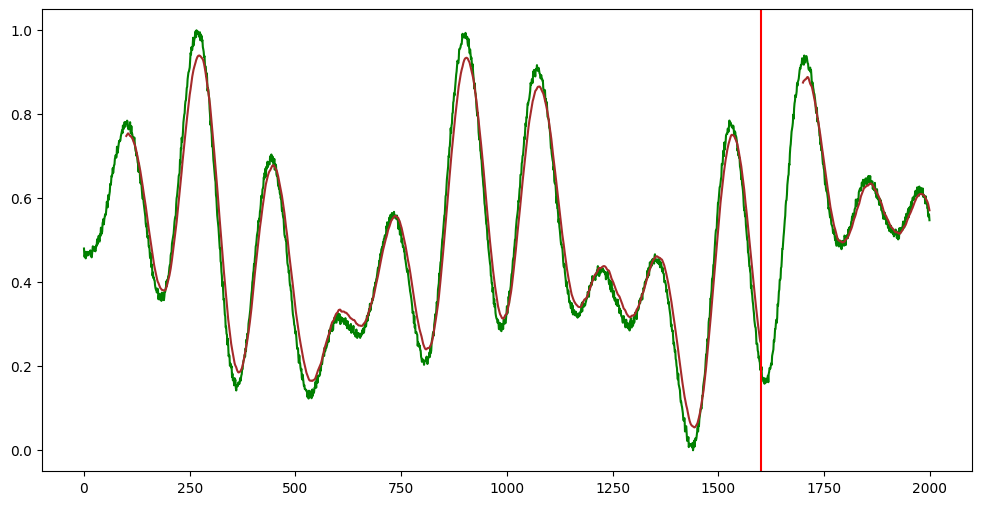

In [32]:
# grafico di confronto dell'output del modello
# rispetto ai dati iniziali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_gru) + step)]
plt.plot(x_train_preds, train_predict_gru, color='brown')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_gru))]
plt.plot(x_test_preds, test_predict_gru, color='brown')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

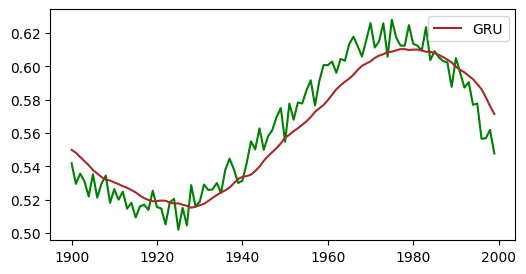

In [33]:
# grafico di dettaglio degli ultimi 100 esempi
# generati dal modello attuale rispetto ai precedenti
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.legend()
plt.show()

In [34]:
# implementazione di un modello di base di rete ricorrente
model_vanilla = Sequential()
model_vanilla.add(SimpleRNN(units=64, input_shape=(step, 1), activation="relu"))
model_vanilla.add(Dense(32, activation="relu"))
model_vanilla.add(Dense(1))
model_vanilla.compile(loss='mean_squared_error', optimizer=Nadam(), metrics=['mean_absolute_error'])
model_vanilla.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [35]:
# addestramento della vanilla RNN
start = timer()
vanilla_h = model_vanilla.fit(train_x, train_y, epochs=10, batch_size=512, verbose=2)
end = timer()
vanilla_t = end - start
print('terminato.')

Epoch 1/10
3/3 - 2s - loss: 0.4331 - mean_absolute_error: 0.5872 - 2s/epoch - 529ms/step
Epoch 2/10
3/3 - 0s - loss: 0.3424 - mean_absolute_error: 0.5190 - 161ms/epoch - 54ms/step
Epoch 3/10
3/3 - 0s - loss: 0.2709 - mean_absolute_error: 0.4588 - 151ms/epoch - 50ms/step
Epoch 4/10
3/3 - 0s - loss: 0.2020 - mean_absolute_error: 0.3902 - 155ms/epoch - 52ms/step
Epoch 5/10
3/3 - 0s - loss: 0.1179 - mean_absolute_error: 0.2855 - 156ms/epoch - 52ms/step
Epoch 6/10
3/3 - 0s - loss: 0.0188 - mean_absolute_error: 0.0941 - 152ms/epoch - 51ms/step
Epoch 7/10
3/3 - 0s - loss: 0.0025 - mean_absolute_error: 0.0428 - 148ms/epoch - 49ms/step
Epoch 8/10
3/3 - 0s - loss: 0.0018 - mean_absolute_error: 0.0353 - 145ms/epoch - 48ms/step
Epoch 9/10
3/3 - 0s - loss: 9.9101e-04 - mean_absolute_error: 0.0259 - 146ms/epoch - 49ms/step
Epoch 10/10
3/3 - 0s - loss: 0.0010 - mean_absolute_error: 0.0277 - 157ms/epoch - 52ms/step
terminato.


In [36]:
# validazione della vanilla RNN
train_predict_vanilla = model_vanilla.predict(train_x)
test_predict_vanilla = model_vanilla.predict(test_x)

10/10 [==============================] - 0s 6ms/step


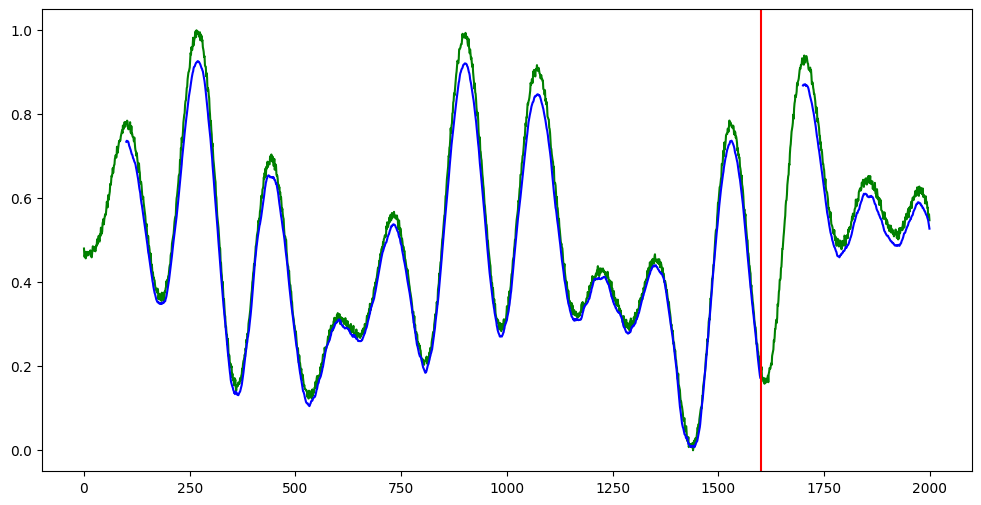

In [37]:
# grafico del confronto tra valori
# predetti e valori reali
index = df.index.values
plt.figure(figsize=(12, 6))
plt.plot(df, color='green')

x_train_preds = [x for x in range(step, len(train_predict_vanilla) + step)]
plt.plot(x_train_preds, train_predict_vanilla, color='blue')

x_test_preds = [test_split_point + x + step for x in range(0, len(test_predict_vanilla))]
plt.plot(x_test_preds, test_predict_vanilla, color='blue')

plt.axvline(df.index[test_split_point], c='r')
plt.show()

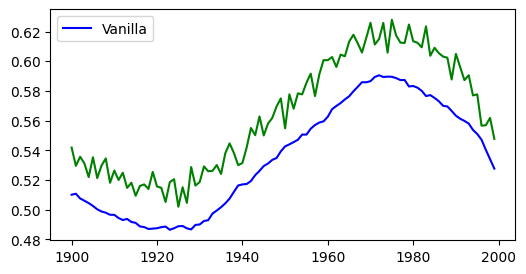

In [38]:
# confronto tra tutti i modelli creati e i dati reali
# per gli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

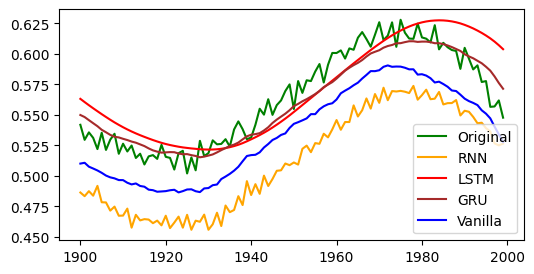

In [39]:
# confronto tra tutti i modelli creati e i dati reali
# per gli ultimi 100 esempi
plt.figure(figsize=(6, 3))
plt.plot(df[-100:], color='green', label='Original')
plt.plot(x_test_preds[-100:], test_predict_rnn[-100:], color='orange', label='RNN')
plt.plot(x_test_preds[-100:], test_predict_lstm[-100:], color='red', label='LSTM')
plt.plot(x_test_preds[-100:], test_predict_gru[-100:], color='brown', label='GRU')
plt.plot(x_test_preds[-100:], test_predict_vanilla[-100:], color='blue', label='Vanilla')
plt.legend()
plt.show()

<Figure size 2000x1200 with 0 Axes>

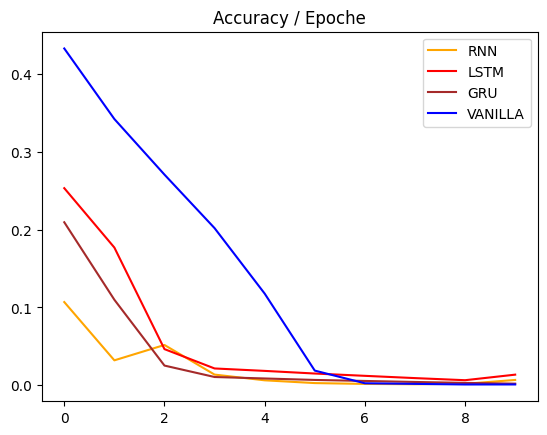

In [40]:
# andamento della Loss tra i vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color='red')
ax.plot(gru_h.history['loss'], color='brown')
ax.plot(vanilla_h.history['loss'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

<Figure size 2000x1200 with 0 Axes>

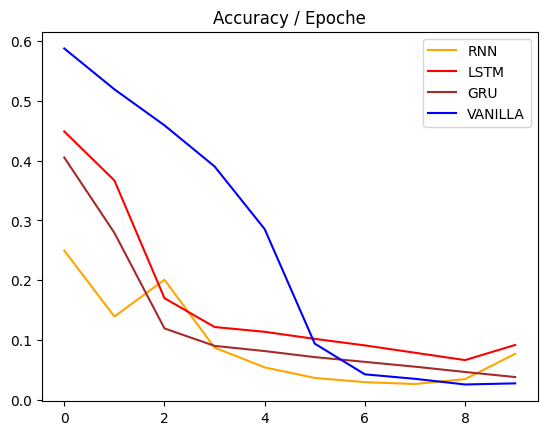

In [41]:
# andamento della Mean Absolute Error tra i vari modelli
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Accuracy / Epoche')
ax.plot(rnn_h.history['mean_absolute_error'], color='orange')
ax.plot(lstm_h.history['mean_absolute_error'], color='red')
ax.plot(gru_h.history['mean_absolute_error'], color='brown')
ax.plot(vanilla_h.history['mean_absolute_error'], color='blue')
ax.legend(['RNN', 'LSTM', 'GRU', 'VANILLA'], loc = 0)
plt.show() 

In [42]:
print('          loss      mae     time')
print('LSTM    ', str(lstm_h.history['loss'][len(lstm_h.history['loss'])-1])[:5], '  ', str(lstm_h.history['mean_absolute_error'][len(lstm_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(lstm_t)[:5])
print('GRU     ', str(gru_h.history['loss'][len(gru_h.history['loss'])-1])[:5], '  ', str(gru_h.history['mean_absolute_error'][len(gru_h.history['mean_absolute_error'])-1])[:5],
      '   ' + str(gru_t)[:5])
print('RNN     ', str(rnn_h.history['loss'][len(rnn_h.history['loss'])-1])[:5], '  ', str(rnn_h.history['mean_absolute_error'][len(rnn_h.history['mean_absolute_error'])-1])[:5],
      '    ' + str(rnn_t)[:4])
print('VANILLA ', str(vanilla_h.history['loss'][len(vanilla_h.history['loss'])-1])[:5], '  ', 
      str(vanilla_h.history['mean_absolute_error'][len(vanilla_h.history['mean_absolute_error'])-1])[:5], '    ' + str(vanilla_t)[:4])

          loss      mae     time
LSTM     0.013    0.091    19.68
GRU      0.002    0.038    17.66
RNN      0.006    0.077     8.05
VANILLA  0.001    0.027     3.02
